# [9] Keras CNN Testing (none,calc,mass)
Same as [8]. This notebook is a bit of a warzone, didn't use results from this in the final report, it was pretty much just initially playing around with keras. Code has NOT been curated and probably won't run straight through. Disregard.

Some code here was used from tutorials, they will be cited properly in the final notebooks

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import seaborn as sns

import pickle
import random
import math as m
import time
import pandas as pd
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
%%time
# loading in important variables

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

# Abnormalities
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
abnorms = []
for i in range(2575):
    if abnormalities[2*i] != abnormalities[2*i+1]:
        print("abnormalities not equal")
    abnorms.append(abnormalities[2*i])
abnorms = np.array(abnorms)

with open('orientations.pkl', 'rb') as f:
    orientations = pickle.load(f)

Wall time: 28.9 ms


In [3]:
from skimage.transform import resize

def rescale_images(input_images, scale):
    new_list = []
    for image in input_images:
        new_list.append(resize(image, scale))
    return new_list

def np_rescale_images(input_images, scale):
    new_array = np.empty((input_images.shape[0], scale[0], scale[1]))
    for i, image in enumerate(input_images):
        new_array[i] = resize(image, scale)
    return new_array

In [4]:
scale = (725, 605)
# scaled_images = rescale_images(images, scale)

In [5]:
def conv_mat(pred, ground, conv_in_percent=False, print_percentages=False, scale_weights=False):
    cats = ground.max()+1
    conmat = np.zeros((cats,cats))
    for i in range(pred.shape[0]):
        y = pred[i]
        x = ground[i]
        if scale_weights: scale = class_weights[x]*class_weights[y]
        else: scale = 1
        conmat[x, y] += 1*scale
    if print_percentages:
        pred_per = np.empty((cats, 2))
        ground_per = np.empty((cats, 2))
        for i in range(cats):
            pred_per[i] = [i,(np.count_nonzero(pred==i)/pred.shape[0])*100]
            ground_per[i] = [i,(np.count_nonzero(ground==i)/pred.shape[0])*100]
        print()
        print(f"Predicted Percentages: \n{pred_per}\n")
        print(f"Ground Percentages: \n{ground_per}\n")
    if conv_in_percent:
        if scale_weights: size = np.sum(conmat)
        else: size = pred.shape[0]
        conmat = np.round_((conmat / size)*100, 1)
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1) 
    sns.heatmap(conmat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    return conmat

In [6]:
def accuracy(pred, ground):
    c = 0
    for i in range(pred.shape[0]):
        if pred[i] == ground[i]:
            c+=1
    return c/pred.shape[0]

In [7]:
## This function will splits the images into three groups side view, bottom view, and a combined concatenated view
## Takes (index, row, col) returns three np arrays in with images in flattened form -
## with shape (image, index) in preparation for PCA
def create_side_bottom_concat(np_imgs, to_print=False, orients=orientations):
    side=[]
    below=[]
    flattened_imgs = np_imgs.reshape(np_imgs.shape[0], np_imgs.shape[1]*np_imgs.shape[2])
    if to_print:
        print(flattened_imgs.shape)
    for i in range(0, flattened_imgs.shape[0]):
        if len(orients[i]) == 2:
            side.append(flattened_imgs[i])
        else:
            below.append(flattened_imgs[i])   
    side = np.array(side)
    below = np.array(below)
    concat = np.concatenate((side, below), 1)
    if to_print:
        print('\nconcatenated images')
        print(f'concat.shape={concat.shape}')
        print('\nside images')
        print(f'side.shape={side.shape}')
        print('\nbelow images')
        print(f'below.shape={below.shape}')
    return side, below, concat

In [8]:
# with open('orientations.pkl', 'rb') as f:
#     orientations = pickle.load(f)
# orientations = np.array(orientations)
# side_scaled, below_scaled, concat_scaled = create_side_bottom_concat(np_scaled_images)

In [9]:
# Set Labels
# label_classes = ["D2 Normal", "Benign", "Malignant"]
label_classes = ["None", "calcification", "mass", "both"]

# for i in range(classes.shape[0]):
#     if classes[i] == "D2 Normal":
#         labels.append(0)
#     else:
#         labels.append(1)
# for i in range(abnorms.shape[0]):
#     if abnorms[i] == "calcification"  or abnorms[i] == "both":
#         labels.append(1)
#     else:
#         labels.append(0)

occurences = [0, 0, 0, 0]
labels = [] 
for i in range(abnorms.shape[0]):
    if abnorms[i] == "D2 Normal":
        labels.append(0)
        occurences[0] += 1
    if abnorms[i] == "calcification":
        labels.append(1)
        occurences[1] += 1
    if abnorms[i] == "mass":
        labels.append(2)
        occurences[2] += 1
    if abnorms[i] == "both":
        labels.append(3)
        occurences[3] += 1
labels = np.array(labels)
print(labels.shape)
print(occurences)

(2575,)
[722, 262, 1137, 454]


In [10]:
%%time
# with open('side_scaled.pkl', 'rb') as f:
#     side_scaled = pickle.load(f)
# with open('below_scaled.pkl', 'rb') as f:
#     below_scaled = pickle.load(f)
# with open('concat_scaled.pkl', 'rb') as f:
#     concat_scaled = pickle.load(f)

Wall time: 998 µs


In [11]:
# dims = 2500
# scans = reduce_dimensionality(concat_imgs.T, vectors, dims).T
# inputs = scans
# reshaped_concat_imgs = concat_imgs.reshape(2575, scale[0]*2, scale[1])
# inputs = np_scaled_images
def set_inputs(new_inputs):
    X_train = new_inputs[train_set]
    X_test = new_inputs[test_set]
    X_validation = new_inputs[validation_set]
    return X_train, X_test, X_validation
#X_train, X_test, X_validation = concat_scaled[train_set], concat_scaled[test_set], concat_scaled[validation_set]
y_train = labels[train_set]
y_test = labels[test_set]
y_validation = labels[validation_set]

In [12]:
# %%time
# with open('concat_train_images.pkl', 'rb') as f:
#     train_images = pickle.load(f)
# with open('concat_test_images.pkl', 'rb') as f:
#     test_images = pickle.load(f)
# with open('concat_validation_images.pkl', 'rb') as f:
#     validation_images = pickle.load(f)

In [13]:
# train_images = np.reshape(train_images, (train_images.shape[0], scale[0]*2, scale[1]))
# test_images = np.reshape(test_images, (test_images.shape[0], scale[0]*2, scale[1]))
# validation_images = np.reshape(validation_images, (validation_images.shape[0], scale[0]*2, scale[1]))

In [14]:
import numpy as np
import mnist
from tensorflow import keras

# The first time you run this might be a bit slow, since the
# mnist package has to download and cache the data.
# train_images = mnist.train_images()
# train_labels = mnist.train_labels()

#train_images = X_train
train_labels = y_train
#test_images = X_test
test_labels = y_test
#validation_images = X_validation
validation_labels = y_validation

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)
print(test_images.shape) # (60000, 28, 28)
print(test_labels.shape) # (60000,)
print(validation_images.shape) # (60000, 28, 28)
print(validation_labels.shape) # (60000,)

NameError: name 'train_images' is not defined

In [ ]:
%%time
# train_images = mnist.train_images()
# train_labels = mnist.train_labels()
# test_images = mnist.test_images()
# test_labels = mnist.test_labels()

# Normalize the images.
# train_images = (train_images / 255) - 0.5
# test_images = (test_images / 255) - 0.5
# validation_images = (validation_images / 255) - 0.5

# Reshape the images.
# train_images = np.expand_dims(train_images, axis=3)
# test_images = np.expand_dims(test_images, axis=3)
# validation_images = np.expand_dims(validation_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)
print(validation_images.shape)  # (10000, 28, 28, 1)

In [15]:
# %%time
# with open('norm_train_images.pkl', 'wb') as f:
#     pickle.dump(train_images, f) 
# with open('norm_test_images.pkl', 'wb') as f:
#     pickle.dump(test_images, f) 
# with open('norm_validation_images.pkl', 'wb') as f:
#     pickle.dump(validation_images, f) 

In [16]:
%%time
import mnist
from tensorflow import keras

with open('norm_train_images.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('norm_test_images.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('norm_validation_images.pkl', 'rb') as f:
    X_validation = pickle.load(f)
    
y_train = labels[train_set]
y_test = labels[test_set]
y_validation = labels[validation_set]

Wall time: 12.4 s


In [17]:
# from collections import Counter
# type(y_train)
# counter = Counter(y_train)                          
# max_val = float(max(counter.values()))       
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
# print(class_weights)
# class_weights[2] = 0.5
# print(class_weights)
print(occurences)
sum_occ = sum(occurences)
print(sum_occ)
occurence_perc = {i: occurences[i]/sum_occ for i in range(len(occurences))}
print(occurence_perc)
max_val = float(max(occurence_perc.values()))
print(max_val)
class_weights = {i: max_val/occurence_perc[i] for i in range(len(occurence_perc))}
print(class_weights)

[722, 262, 1137, 454]
2575
{0: 0.2803883495145631, 1: 0.10174757281553398, 2: 0.44155339805825244, 3: 0.17631067961165048}
0.44155339805825244
{0: 1.5747922437673132, 1: 4.3396946564885495, 2: 1.0, 3: 2.5044052863436126}


In [20]:
%%time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

num_filters = 32 # 8
filter_size = 3 # 3
pool_size = 2 # 2
with tf.device("/cpu:0"):
    model = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(scale[0]*2, scale[1], 1), strides=2, padding='same', activation='relu'),
      Conv2D(num_filters, filter_size, strides=2, padding='same', activation='relu'),
      MaxPooling2D(pool_size=pool_size),
      Dropout(0.2),
      Flatten(),
      Dense(40, activation='relu'),
      Dense(4, activation='softmax'),
    ])
epochs_on_model = 0

Wall time: 90.8 ms


In [21]:
%%time
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

Wall time: 3.99 ms


In [22]:
%%time
from tensorflow.keras.utils import to_categorical
epochs_this = 20
epochs_on_model += epochs_this
with tf.device("/cpu:0"):
    model.fit(
      X_train,
      to_categorical(y_train),
      epochs=epochs_this,
      validation_data=(X_test, to_categorical(y_test)),
      class_weight=class_weights, 
    )

Epoch 1/20
65/65 [==============================] - 115s 2s/step - loss: 2.6575 - accuracy: 0.3311 - val_loss: 1.3858 - val_accuracy: 0.4457
Epoch 2/20
65/65 [==============================] - 104s 2s/step - loss: 2.4416 - accuracy: 0.3262 - val_loss: 1.3864 - val_accuracy: 0.4457
Epoch 3/20
65/65 [==============================] - 103s 2s/step - loss: 2.4417 - accuracy: 0.2272 - val_loss: 1.3860 - val_accuracy: 0.1434
Epoch 4/20
65/65 [==============================] - 103s 2s/step - loss: 2.4417 - accuracy: 0.2141 - val_loss: 1.3858 - val_accuracy: 0.4457
Epoch 5/20
65/65 [==============================] - 101s 2s/step - loss: 2.4416 - accuracy: 0.4199 - val_loss: 1.3856 - val_accuracy: 0.4457
Epoch 6/20
65/65 [==============================] - 102s 2s/step - loss: 2.4416 - accuracy: 0.4437 - val_loss: 1.3843 - val_accuracy: 0.4457
Epoch 7/20
65/65 [==============================] - 102s 2s/step - loss: 2.4417 - accuracy: 0.4442 - val_loss: 1.3848 - val_accuracy: 0.4457
Epoch 8/20
65

Epochs so far: 20

65/65 [==============================] - 25s 312ms/step
Train Accuracy = 0.4441747572815534
9/9 [==============================] - 3s 265ms/step
Test Accuracy = 0.44573643410852715
9/9 [==============================] - 3s 268ms/step
Validation Accuracy = 0.4163424124513619

Predicted Percentages: 
[[  0.   0.]
 [  1.   0.]
 [  2. 100.]
 [  3.   0.]]

Ground Percentages: 
[[ 0.         26.07003891]
 [ 1.         11.28404669]
 [ 2.         41.63424125]
 [ 3.         21.01167315]]



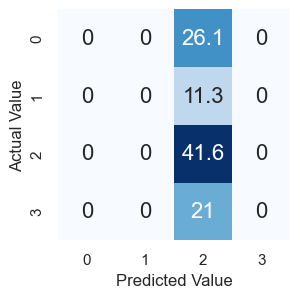

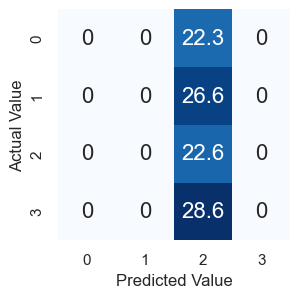

In [24]:
with tf.device("/cpu:0"):
    print(f"Epochs so far: {epochs_on_model}\n")

    raw_predictions = model.predict(X_train)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Train Accuracy = {accuracy(predictions, y_train)}")

    raw_predictions = model.predict(X_test)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Test Accuracy = {accuracy(predictions, y_test)}")

    raw_predictions = model.predict(X_validation)
    predictions = np.argmax(raw_predictions, axis=1)
    print(f"Validation Accuracy = {accuracy(predictions, y_validation)}")

    # print(f"Convolution Matrix:\n{conv_mat(predictions, y_validation, True, True)}")
    # print(f"Scaled Convolution Matrix:\n{conv_mat(predictions, y_validation, True, False, True)}")
    unscaled_conv = conv_mat(predictions, y_validation, True, True)
    scaled_conv = conv_mat(predictions, y_validation, True, False, True)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


In [93]:
model.save_weights('3ClassModel_1.h5')

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(2*scale[0], scale[1], 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(3, activation='softmax'),
])

# Load the model's saved weights.
model.load_weights('3ClassModel_1.h5')

In [110]:
# Predict on the first 5 test images.
raw_predictions = model.predict(X_test)
predictions = np.argmax(raw_predictions, axis=1)
# Print our model's predictions.
print(predictions) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(y_test) # [7, 2, 1, 0, 4]

9/9 [==============================] - 0s 19ms/step
[2 0 0 2 1 0 2 0 2 0 1 0 2 0 2 2 1 2 1 2 2 0 2 1 0 2 2 0 2 2 2 1 0 2 2 1 2
 1 2 1 2 1 2 1 1 2 0 2 1 2 1 2 0 2 0 0 1 0 2 0 1 0 2 2 0 2 2 2 2 1 0 2 2 2
 0 2 2 2 0 1 2 0 2 0 2 2 2 2 2 1 0 2 2 2 0 1 0 0 1 2 0 1 0 1 0 2 1 1 1 1 1
 2 0 2 0 0 2 0 0 2 1 1 1 2 2 2 2 0 2 2 2 0 2 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2
 2 2 0 0 1 0 0 0 2 2 2 1 2 0 1 2 0 2 2 2 2 2 1 2 0 1 0 1 2 2 0 0 1 2 2 0 2
 0 2 2 0 1 1 0 2 1 0 2 2 1 2 2 0 1 0 2 1 1 1 1 1 2 2 2 2 2 1 1 2 0 0 2 2 2
 1 0 0 0 0 0 1 2 0 0 2 2 0 1 2 2 2 2 2 2 2 2 1 0 1 0 0 2 2 2 2 2 2 2 2 2]
[1 2 0 1 1 2 1 0 2 2 2 2 0 1 2 0 0 2 0 0 2 2 2 1 2 2 2 2 2 0 0 2 0 0 2 1 2
 0 2 0 0 0 2 2 2 0 2 2 2 2 0 0 2 0 1 2 2 2 0 2 0 0 1 2 2 2 2 2 2 1 2 2 1 2
 2 2 1 0 0 2 2 2 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 1 0 2 1 2 0
 2 1 2 2 0 0 0 0 2 2 1 2 0 2 0 0 2 2 0 2 0 2 0 2 2 2 2 1 0 2 1 2 2 2 0 2 0
 2 0 2 2 0 2 1 2 2 2 1 0 2 2 2 2 2 1 0 2 1 2 0 2 1 2 2 1 1 2 2 0 0 2 1 1 1
 0 2 2 2 2 0 0 2 0 0 2 0 2 1 1 2 0 0 0 2 2 2 0 2 

In [108]:
def accuracy(pred, ground):
    c = 0
    for i in range(pred.shape[0]):
        if pred[i] == ground[i]:
            c+=1
    return c/pred.shape[0]

In [114]:
accuracy(predictions, y_test)

(258,) (258,)


0.3798449612403101